<a href="https://colab.research.google.com/github/LeonMilosevic/fraud_homework_redo/blob/main/fraud_homework_redo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Concept of the Notebook

Notebook will consists out of 5 parts.

1. Analysis
  - Explore the dataset
  - Find insights
  - Draw conclusions
  - Get ideas for feature engineering

2. Base model
  - We will create a base model and have a benchmark for the performence.

3. Feature Engineering
  - Improve the results and build upon discoveries from Analysis part.

4. Modeling
  - Model optimization, and performence tuning.
  - Draw business conclusions

5. Business presentation and final conclusions.
  - We will make a conclusion, sum up all previous chapters, present our solution and advice on how to improve the business model of detecting fraudulent transactions.

# Imports and libraries 

In [3]:
!pip install pgeocode
!pip install folium
!pip install pycountry
!pip install beautifulsoup4
!pip install catboost

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from statistics import mean

from catboost import CatBoostClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import pycountry
import pgeocode
import folium
from folium import Marker

from scipy import stats

from bs4 import BeautifulSoup
import requests

from helper_functions import get_postal_code, get_time_difference, check_missing_values, split_zip_codes, zip_encoder

import warnings
warnings.filterwarnings('ignore')

# Analysis

In [5]:
transaction_data = pd.read_csv('transactions_obf.csv')
labels_data = pd.read_csv('labels_obf.csv')

# adding target value to labels_data and merging the dataframes
labels_data['target'] = 1
data = pd.merge(transaction_data, labels_data, how="left", on="eventId")

data[['target']] = data[['target']].fillna(value=0)

# converting time column and setting time as index
data['transactionTime'] = pd.to_datetime(data['transactionTime'])

data.shape

(118621, 12)

###### Split into train/test data based on time

In [6]:
train_data = data[data['transactionTime'] < "2018-01-01"]
test_data = data[data['transactionTime'] > "2018-01-01"]

print(train_data.shape)
print(test_data.shape)

(110090, 12)
(8531, 12)


###### Target Distribution

In [7]:
# proportion of fraud transactions
train_data['target'].value_counts(normalize=True)

0.0    0.992406
1.0    0.007594
Name: target, dtype: float64

- We are dealing with class imbalance

###### Total transactions per country

In [8]:
train_data.groupby(['merchantCountry']).target.count().sort_values(ascending=False).head(5)

merchantCountry
826    88908
442    13819
840     2640
372     1236
250      429
Name: target, dtype: int64

We can see that most of the transactions come from Great Britain,
since country code 826 = GB

###### Zip Codes per country

In [9]:
# transform to uppercase as to avoid same values with different cases
train_data['merchantZip'] = train_data['merchantZip'].str.upper()

# getting unique countries values
unique_countries = train_data['merchantCountry'].unique().tolist()

# number of unique zip codes per country
unique_zips = []
for i in unique_countries:
  unique_zips.append(len(train_data.loc[train_data['merchantCountry'] == i]['merchantZip'].unique()))

temp_data = {"country_code": unique_countries, "num_of_unique_zip_codes": unique_zips}
zip_codes_per_country_df = pd.DataFrame(temp_data)
zip_codes_per_country_df.head(5)

,country_code,num_of_unique_zip_codes
0,826,3099
1,442,1
2,392,1
3,36,1
4,372,1


In [10]:
len(train_data['merchantZip'].unique())

3100

We can see that all merchant zip codes come from Great Britain, while zip codes from countries other than GB were not registered or are unknown.

###### Taking a closer look at GB

In [11]:
gb_data = train_data.loc[train_data['merchantCountry'] == 826]

# total unique number of strings lengths for zip codes
zip_lengths = len(gb_data['merchantZip'].str.len().value_counts().index.to_list())

# number of unique zip code values based on their length
for i in range(zip_lengths):
  print(i+1, len(gb_data.loc[gb_data['merchantZip'].str.len() == i+1]['merchantZip'].unique()))

1 2
2 4
3 1087
4 1263
5 743


**Note:** Zip Code Fact 1.0

* Zip code pattern for GB is letter+digit

###### Invalid Zip codes, based on Zip Code Fact 1.0

In [12]:
# finding non alpha numeric values
non_alpha_numeric = gb_data[gb_data['merchantZip'].str.contains('(\W+)')]['merchantZip'].unique().tolist()

# finding values that only contain digits
only_numeric = gb_data[gb_data['merchantZip'].str.contains('^([\s\d]+)$')]['merchantZip'].unique().tolist()

# finding values that only contain alphabetic chars
only_alphabetic_chars = gb_data[gb_data['merchantZip'].str.contains('^[a-zA-Z]+$')]['merchantZip'].unique().tolist()

invalid_zip_values = non_alpha_numeric + only_numeric + only_alphabetic_chars

In [13]:
invalid_zip_values[:5]

['....', '...', '***', '.....', '**']

###### Number of transactions for each invalid zip code

In [14]:
invalid_zip_transactions = []
for zip in invalid_zip_values:
  invalid_zip_transactions.append(gb_data.loc[gb_data['merchantZip'] == zip].shape[0])

temp_data = {"zip_codes": invalid_zip_values, "transactions": invalid_zip_transactions}
df = pd.DataFrame(temp_data)

df.sort_values(by=['transactions'], ascending=False).head(5)

,zip_codes,transactions
6,0,13554
1,...,374
0,....,361
7,11111,35
19,F,27


In [15]:
# count of transactions for valid + invalid zip values
gb_data.groupby(['merchantZip']).count().target.sort_values(ascending=False)

merchantZip
0        13554
E12       1063
SL4        614
LS11       570
CO10       512
         ...  
E83NS        1
E83DG        1
E82NS        1
E82JP        1
YO8          1
Name: target, Length: 3099, dtype: int64

Given that merchantZip "0" has the highest number of transactions in GB, we can't assume that it is coming from one/same location. We should then encode it as a geolocation from GB.

**Note:** Zip Code Fact 1.1

* All codes in GB that have 5 characters, have space before 3rd character

###### Fixing zip codes based on Zip Code Fact 1.1

In [16]:
gb_data['merchantZip'] = split_zip_codes(gb_data, 5)

###### Adding longitude and latitude to each sample based on Zip address

In [17]:
nomi = pgeocode.Nominatim('gb')

# encoding known zip codes
gb_zip_codes = pd.DataFrame({"zip_codes": gb_data['merchantZip'].unique()})

gb_zip_codes[['Latitude', 'Longitude', 'state_name']] = gb_zip_codes.apply(lambda x: get_postal_code(nomi, x['zip_codes']), axis=1)

print("{}% of addresses were geocoded!".format(
    (1 - sum(np.isnan(gb_zip_codes["Latitude"])) / len(gb_zip_codes)) * 100))

95.70829299774121% of addresses were geocoded!


In [18]:
not_found_zip_codes = gb_zip_codes[gb_zip_codes['Latitude'].isnull()]
not_found_zip_codes['zip_codes'].str.len().value_counts()

4    70
3    41
6    16
2     4
1     2
Name: zip_codes, dtype: int64

After manually examining some codes, most of them are districts with missing street numbers or the codes are no longer in use.

* There are some geopy maps that could potentionally find the geolocation of a district, unfortunatelly, free-tier maps do not work well with districts or not in use post-codes.

* We will encode all the non-found zip_codes with geolocation of GB

* Countries other than GB, since they are missing merchantZip, will be encoded by their country Long/Lat

###### Account number exploration

In [19]:
# repeated transactions
train_data[train_data['target'] == 1]['accountNumber'].value_counts()[:20]

8b9c15ea    97
3ec9dda7    59
6bab7602    48
39219923    45
7728d696    41
1602df4e    41
749acd16    24
0646d69d    24
bd9f22c1    18
50a66385    16
ab09dc29    14
c8e8e50e    10
3c971982    10
3e772d6b     9
6c8aab9a     9
f42ba1f1     8
5576aade     7
23ce118b     7
2607f05b     6
f8e83776     6
Name: accountNumber, dtype: int64

- We can see repeated transactions coming from same accounts, we will explore later in what interval of time fraud transactions happen.

###### Explore PosEntryMode

In [20]:
train_data['posEntryMode'].value_counts()

5     65262
81    33189
1      9875
90     1047
7       569
80       91
79       31
2        13
0        10
91        3
Name: posEntryMode, dtype: int64

In [21]:
train_data[train_data['target'] == 1]['posEntryMode'].value_counts()

81    618
1     188
5      17
90      9
2       2
0       2
Name: posEntryMode, dtype: int64

Most of the transactions come from POS Entry Circuit Card, and most fraudulent transactions come from POS Entry E-Commerce

###### Exploring Time

Difference in median time between given accounts with fraudulent transactions and non-fraudulent transactions.

In [22]:
# median time of fraudulent transactions by account number
fraud_time_med = []

for account in train_data[train_data['target']==1]['accountNumber'].unique().tolist():
  acc_time = get_time_difference(train_data, 'accountNumber', account, 'transactionTime', 1)
  if len(acc_time) == 0:
    fraud_time_med.append(0)
  else:
    fraud_time_med.append(np.median(acc_time))

# median time of non-fraudulent transactions by account number
non_fraud_time_med = []

for account in train_data[train_data['target'] == 0]['accountNumber'].unique().tolist():
  acc_time = get_time_difference(train_data, 'accountNumber', account, 'transactionTime', 0)
  if len(acc_time) == 0:
    non_fraud_time_med.append(0)
  else:
    non_fraud_time_med.append(np.median(acc_time))

In [23]:
print(f'fraud: {np.median(fraud_time_med)}')
print(f'not-fraud: {np.median(non_fraud_time_med)}')

fraud: 12.583333333333334
not-fraud: 1609.475


Fraud transactions happen in a shorter span of time then regular ones.

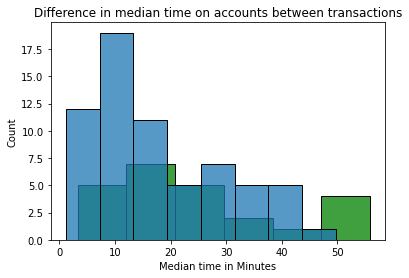

In [24]:
# comparing distribution between fraud and non-fraud transactions within the first hour
ax = sns.histplot([i for i in non_fraud_time_med if i != 0 and i < 60], color='green')
sns.histplot([i for i in fraud_time_med if i != 0 and i < 60])
ax.set(xlabel='Median time in Minutes', ylabel='Count', title='Difference in median time on accounts between transactions')
plt.show()

From this plot we can see that fraudulent transactions happen consecutively more often in the first 15 minutes than legitimate transactions.

A good business decision would be to block the card if more than 4-5 consecutive transactions happen in the first 5-10 minutes, until client can confirm transactions over the app, or via call from customer support agent. For example.

###### Exploring continues variables

In [25]:
print(f"fraud median: {train_data[train_data['target'] == 1]['transactionAmount'].median()}")
print(f"non-fraud median: {train_data[train_data['target'] == 0]['transactionAmount'].median()}")

fraud median: 21.0
non-fraud median: 20.32


In [26]:
print(f"fraud median: {train_data[train_data['target'] == 1]['availableCash'].median()}")
print(f"non-fraud median: {train_data[train_data['target'] == 0]['availableCash'].median()}")

fraud median: 4500.0
non-fraud median: 7500.0


We can spot a difference in available cash amount between fraud and non-fraud transactions. 

# Baseline Model

In [27]:
x_train = data[data['transactionTime'] < '2017-12-01'].drop(['reportedTime', 'target', 'eventId'], axis=1).fillna('unknown')
y_train = data[data['transactionTime'] < '2017-12-01']['target']

x_valid = data[data['transactionTime'] > '2017-12-01'].drop(['reportedTime', 'target', 'eventId'], axis=1).fillna('unknown')
y_valid = data[data['transactionTime'] > '2017-12-01']['target']

In [28]:
cat_features = ['accountNumber', 'merchantId', 'mcc', 'merchantCountry', 'merchantZip', 'posEntryMode']

cbc = CatBoostClassifier(
    random_seed=42,
    verbose=100,
)

cbc.fit(x_train, y_train, cat_features = cat_features)  

Learning rate set to 0.073912
0:	learn: 0.5311148	total: 198ms	remaining: 3m 17s
100:	learn: 0.0139377	total: 13.6s	remaining: 2m
200:	learn: 0.0121962	total: 28.8s	remaining: 1m 54s
300:	learn: 0.0112475	total: 43.5s	remaining: 1m 40s
400:	learn: 0.0102732	total: 57.5s	remaining: 1m 25s
500:	learn: 0.0095809	total: 1m 13s	remaining: 1m 13s
600:	learn: 0.0089913	total: 1m 28s	remaining: 59s
700:	learn: 0.0083972	total: 1m 45s	remaining: 44.8s
800:	learn: 0.0077938	total: 2m	remaining: 30s
900:	learn: 0.0072517	total: 2m 16s	remaining: 15s
999:	learn: 0.0067386	total: 2m 32s	remaining: 0us


In [29]:
confusion_matrix(y_valid, cbc.predict(x_valid)) # with class_weight=None

array([[17539,    35],
       [   82,     1]])

In [30]:
y_valid.value_counts()

0.0    17574
1.0       83
Name: target, dtype: int64

# Feature Engineering

In [31]:
url = "https://developers.google.com/public-data/docs/canonical/countries_csv"
page = requests.get(url)
soup = BeautifulSoup(page.content, "html.parser")

# encoding location based on zip codes and country
df_data = zip_encoder(data, pgeocode, pycountry, soup)


In [32]:
acc_nums = df_data.accountNumber.unique().tolist()

In [79]:
temp_df = pd.DataFrame(df_data[['eventId', 'transactionTime']])

for acc in acc_nums:
  # dataframe should contain 15 columns of time_diff for each acc
  acc_df = pd.DataFrame(df_data[df_data['accountNumber'] == acc].sort_values(by='transactionTime'))

  for i in range(15):
    acc_time_difference = df_data[df_data['accountNumber'] == acc].sort_values(by='transactionTime').set_index('eventId')['transactionTime'].diff(periods=i+1).apply(lambda x: x/np.timedelta64(1, 'm')).fillna(0).astype('int64')
    temp_df_2 = pd.DataFrame({"eventId": acc_time_difference.index, 'transactionTime': acc_time_difference.values})
    acc_df.merge(temp_df_2, how='inner', on="eventId")
  # append acc_df to temp_df
  temp_df.append(acc_df)

In [80]:
temp_df

,eventId,transactionTime
0,18688431A1,2017-01-01 00:00:00+00:00
1,55451345A1,2017-01-01 10:13:48+00:00
2,246068A1,2017-01-02 21:06:15+00:00
3,7301906A1,2017-01-03 15:52:48+00:00
4,231284A1,2017-01-04 12:47:34+00:00
...,...,...
118616,93946923A1,2017-11-28 08:18:26+00:00
118617,15277454A1,2017-12-09 23:47:53+00:00
118618,89825209A1,2017-12-24 20:54:34+00:00
118619,81464676A1,2018-01-14 14:59:29+00:00


In [93]:
temp_df = pd.DataFrame()

# time difference between previous transaction
acc_df = df_data[df_data['accountNumber'] == '446aa601'].sort_values(by='transactionTime').set_index('eventId')['transactionTime'].diff(periods=1).apply(lambda x: x/np.timedelta64(1, 'm')).fillna(0).astype('int64')
acc_df_2 = df_data[df_data['accountNumber'] == '446aa601'].sort_values(by='transactionTime').set_index('eventId')['transactionTime'].diff(periods=2).apply(lambda x: x/np.timedelta64(1, 'm')).fillna(0).astype('int64')

df_1 = pd.DataFrame({"eventId": acc_df.index, "transactionTime_1": acc_df.values})
df_2 = pd.DataFrame({"eventId": acc_df_2.index, "transactionTime_1": acc_df_2.values})

combined = pd.merge(df_1, df_2, how="inner", on="eventId")
temp_df = temp_df.append(combined)

In [85]:
pd.DataFrame(df_data[df_data['accountNumber'] == '446aa601'].sort_values(by='transactionTime')[['eventId','transactionTime']])

,eventId,transactionTime
33171,245540A1,2017-01-02 13:02:46+00:00
2,246068A1,2017-01-02 21:06:15+00:00
47019,241748A1,2017-01-03 12:01:59+00:00
47018,228788A1,2017-01-03 12:36:17+00:00
4,231284A1,2017-01-04 12:47:34+00:00
...,...,...
66218,246500A1,2018-01-26 23:56:14+00:00
66217,244772A1,2018-01-27 00:16:13+00:00
66219,232964A1,2018-01-28 16:43:40+00:00
94157,246980A1,2018-01-28 21:21:50+00:00


In [82]:
# time difference between 2 previous transaction
df_data[df_data['accountNumber'] == '446aa601'].sort_values(by='transactionTime')['transactionTime'].diff(periods=2).apply(lambda x: x/np.timedelta64(1, 'm')).fillna(0).astype('int64')

33171       0
2           0
47019    1379
47018     930
4        1485
         ... 
66218    4520
66217    1541
66219    2447
94157    2705
47166    1297
Name: transactionTime, Length: 383, dtype: int64

In [36]:
# time difference between 3 previous transaction
df_data[df_data['accountNumber'] == '446aa601'].sort_values(by='transactionTime')['transactionTime'].diff(periods=3).apply(lambda x: x/np.timedelta64(1, 'm')).fillna(0).astype('int64')

33171       0
2           0
47019       0
47018    1413
4        2381
         ... 
66218    4675
66217    4540
66219    3968
94157    2725
47166    3724
Name: transactionTime, Length: 383, dtype: int64

In [37]:
# time difference between 4 previous transaction
df_data[df_data['accountNumber'] == '446aa601'].sort_values(by='transactionTime')['transactionTime'].diff(periods=4).apply(lambda x: x/np.timedelta64(1, 'm')).fillna(0).astype('int64')

33171       0
2           0
47019       0
47018       0
4        2864
         ... 
66218    6493
66217    4695
66219    6968
94157    4247
47166    3744
Name: transactionTime, Length: 383, dtype: int64

In [38]:
# time difference between 5 previous transaction
df_data[df_data['accountNumber'] == '446aa601'].sort_values(by='transactionTime')['transactionTime'].diff(periods=5).apply(lambda x: x/np.timedelta64(1, 'm')).fillna(0).astype('int64')

33171       0
2           0
47019       0
47018       0
4           0
         ... 
66218    6800
66217    6513
66219    7122
94157    7246
47166    5266
Name: transactionTime, Length: 383, dtype: int64

In [39]:
# time difference between 6 previous transaction
df_data[df_data['accountNumber'] == '446aa601'].sort_values(by='transactionTime')['transactionTime'].diff(periods=6).apply(lambda x: x/np.timedelta64(1, 'm')).fillna(0).astype('int64')

33171       0
2           0
47019       0
47018       0
4           0
         ... 
66218    8877
66217    6820
66219    8940
94157    7400
47166    8265
Name: transactionTime, Length: 383, dtype: int64

In [40]:
# time difference between 7 previous transaction
df_data[df_data['accountNumber'] == '446aa601'].sort_values(by='transactionTime')['transactionTime'].diff(periods=7).apply(lambda x: x/np.timedelta64(1, 'm')).fillna(0).astype('int64')

33171       0
2           0
47019       0
47018       0
4           0
         ... 
66218    8958
66217    8897
66219    9247
94157    9218
47166    8419
Name: transactionTime, Length: 383, dtype: int64

In [41]:
# time difference between 8 previous transaction
df_data[df_data['accountNumber'] == '446aa601'].sort_values(by='transactionTime')['transactionTime'].diff(periods=8).apply(lambda x: x/np.timedelta64(1, 'm')).fillna(0).astype('int64')

33171        0
2            0
47019        0
47018        0
4            0
         ...  
66218     9849
66217     8978
66219    11325
94157     9525
47166    10237
Name: transactionTime, Length: 383, dtype: int64

In [42]:
# time difference between 9 previous transaction
df_data[df_data['accountNumber'] == '446aa601'].sort_values(by='transactionTime')['transactionTime'].diff(periods=9).apply(lambda x: x/np.timedelta64(1, 'm')).fillna(0).astype('int64')

33171        0
2            0
47019        0
47018        0
4            0
         ...  
66218    10686
66217     9869
66219    11405
94157    11603
47166    10544
Name: transactionTime, Length: 383, dtype: int64

In [43]:
# time difference between 10 previous transaction
df_data[df_data['accountNumber'] == '446aa601'].sort_values(by='transactionTime')['transactionTime'].diff(periods=10).apply(lambda x: x/np.timedelta64(1, 'm')).fillna(0).astype('int64')

33171        0
2            0
47019        0
47018        0
4            0
         ...  
66218    11189
66217    10706
66219    12296
94157    11684
47166    12622
Name: transactionTime, Length: 383, dtype: int64

In [44]:
df_data[df_data['accountNumber'] == '446aa601'].sort_values(by='transactionTime')

,transactionTime,eventId,accountNumber,merchantId,mcc,merchantCountry,merchantZip,posEntryMode,transactionAmount,availableCash,reportedTime,target,state_name,Latitude,Longitude
33171,2017-01-02 13:02:46+00:00,245540A1,446aa601,7c3a49,5912,826,E12,5,12.60,7500,NaN,0.0,England,51.5508,0.052800
2,2017-01-02 21:06:15+00:00,246068A1,446aa601,efe82d,7523,826,CR0,90,4.08,7500,NaN,0.0,England,51.3500,-0.060975
47019,2017-01-03 12:01:59+00:00,241748A1,446aa601,1bad26,5411,826,CT1,5,32.23,8500,NaN,0.0,England,51.2790,1.068350
47018,2017-01-03 12:36:17+00:00,228788A1,446aa601,10cad1,5732,826,CT1,5,200.03,7500,NaN,0.0,England,51.2790,1.068350
4,2017-01-04 12:47:34+00:00,231284A1,446aa601,efe82d,7523,826,CR0,90,4.15,8500,NaN,0.0,England,51.3500,-0.060975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66218,2018-01-26 23:56:14+00:00,246500A1,446aa601,12e993,5411,826,CT5,5,34.70,8500,NaN,0.0,England,51.3612,1.040014
66217,2018-01-27 00:16:13+00:00,244772A1,446aa601,12e993,5411,826,CT5,5,11.69,8500,NaN,0.0,England,51.3612,1.040014
66219,2018-01-28 16:43:40+00:00,232964A1,446aa601,bc4a14,5631,826,CT5,5,56.00,8500,NaN,0.0,England,51.3612,1.040014
94157,2018-01-28 21:21:50+00:00,246980A1,446aa601,35ada2,7523,826,DA10,5,6.00,8500,NaN,0.0,England,51.4463,0.325500
